In [165]:
import pandas as pd
import numpy as np
import importlib

import utils_data_preprocessing
import lstm_classifier
import post_inference
# Reload the module
importlib.reload(utils_data_preprocessing)
importlib.reload(lstm_classifier)
importlib.reload(post_inference)

# Reinitialize the class
from utils_data_preprocessing import Utils_data_preprocessing
from lstm_classifier import Lstm_classifier
from post_inference import Post_inference

In [166]:
# Reset tensoflow, each time you run, the run's model is save, generate conflits with the code
from tensorflow.keras.backend import clear_session
clear_session()  # Resets the backend state

### Data preprocessing

In [167]:
SELECTED_DISASTER_TYPES=["Storm"] # Storm, Flood, 

In [168]:
emdat = pd.read_csv("data/emdat_south_states.csv")


clean_emdat = Utils_data_preprocessing().clean_emdat(emdat_df=emdat, 
                                                   minimum_start_year=2010, # disasters previous this year are discarded (minmum: 2010)
                                                   accepted_disasters_types=SELECTED_DISASTER_TYPES) # other disasters with types diferent from this are removed

In [169]:
noaa = pd.read_csv("data/DEFINITIVO1_merged_noaa_meteostat_prism.csv")

# Replace NAN's by median of numeric columns only. 
numeric_cols = noaa.select_dtypes(include='number')  # Select only numeric columns
noaa[numeric_cols.columns] = numeric_cols.apply(lambda col: col.fillna(col.median()))

N_AFTER_DISASTER_DAYS_TO_LABEL = 0 # only the first day of the diaster is labelled no more, RECOMMENDED TO NOT CHANGE THIS
noaa_counted = Utils_data_preprocessing().count_diasters_by_day(clean_emdat_df=clean_emdat, 
                                                              noaa_df=noaa, 
                                                              n_after_disaster_days_to_label= N_AFTER_DISASTER_DAYS_TO_LABEL) # if the disaster lasts more than n_after_disaster_days_to_label=2 days, only the first n_after_disaster_days_to_label=2 days are counted as disaster 

### Feature engineering
<br>Choose if want date for an entire state or for an individual station

In [170]:
N_NEXT_DAYS_UNTIL_DISASTER = 20
LENGTHS_DAYS_MA = [10, 20, 40]
MAX_LAG_PERIOD = 5
SELECTED_STATE='Kansas'

In [171]:
model_ready_data = Utils_data_preprocessing().prepare_state_version_data_for_model(data=noaa_counted, 
                                                                selected_state=SELECTED_STATE, # rest of states are removed. States: 'Arkansas', 'Kansas', 'Texas', 'Oklahoma', 'Louisiana', 'Mississippi'
                                                                n_next_days_until_disaster=N_NEXT_DAYS_UNTIL_DISASTER, # if =7 predict if it will ocurr a disaster the next 7 days, if a disaster ocurred the 8th of April, 1st to 7th of April will be also labelled as disaster (1)
                                                                lengths_days_ma=LENGTHS_DAYS_MA, # the number of days of Moving Averages, 7-day-MA, 21-day-MA. Each one is a new computed variable
                                                                max_lag_period=MAX_LAG_PERIOD) # how many days we are looking back, if =7, we are creating 7new variables with the past values of the last 7 days of EACH variable

Adjust the target like this: <br>
[0,   1,     1,    1,    1,    1,    1, 1, 1, 1, 1] adjust to <br>
[0, 0.14, 0.29, 0.43, 0.57, 0.71, 0.86, 1, 1, 1, 1]

In [172]:
# OPTIONAL. if you do not want to adjust set = False
WANT_TO_ADJUST_TARGET = False
if WANT_TO_ADJUST_TARGET:
    model_ready_data['target'] = Utils_data_preprocessing().adjust_days_previous_disaster(column_to_adjust=model_ready_data['target'], 
                                                                                        n_next_days_until_disaster=N_NEXT_DAYS_UNTIL_DISASTER) # IT HAS TO BE THE SAME AS BEFORE (before=the .prepare_ function)

In [173]:
cols_not_scale = [col for col in model_ready_data.columns 
                  if 'WT' in col or 'season' in col or 'target' in col]

scaled_data = Lstm_classifier().scale_data(data=model_ready_data, 
                                           choosen_scaler='standard', # 'standard', 'minmax', 'quantile'
                                           cols_not_scale=cols_not_scale)

## Training

In [174]:
SEQUENCE_LENGTH = 20
VAL_MAXIMUM_SIZE=60 # this is the number of days to predict after the train data

Training with 90% of the data
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step


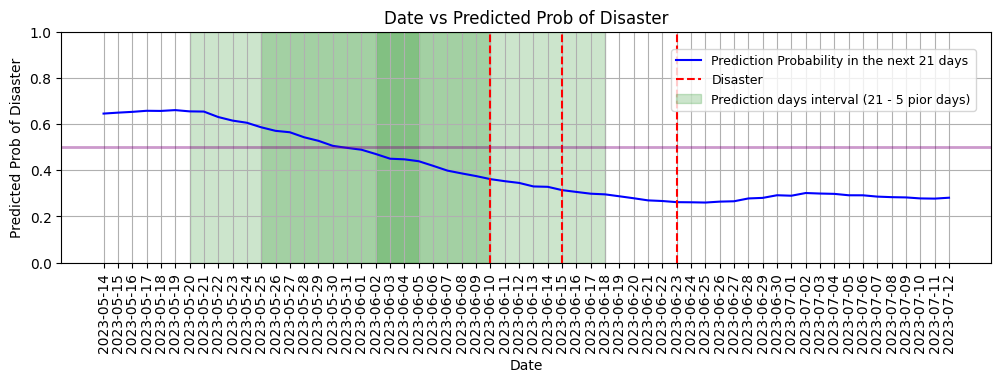

Number of disasters in this period 3
refined_recall when predicting between 21 - 5 days previous a disaster: 0.667
-------------- End of iteration ------------------

Training with 92% of the data
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


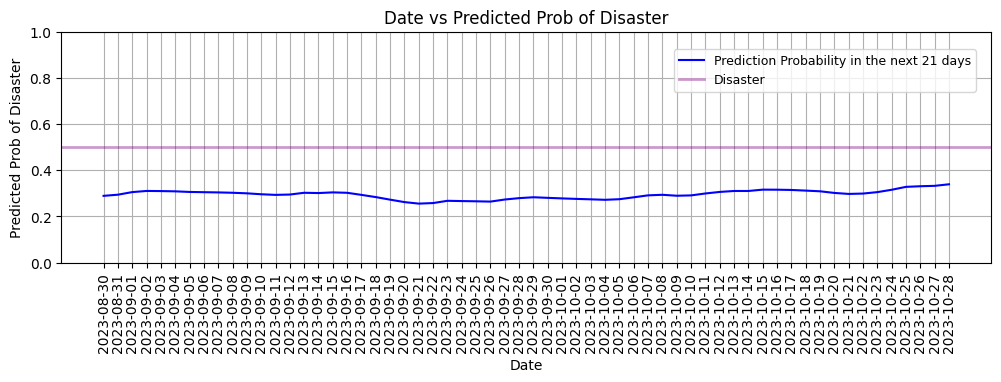

Number of disasters in this period 0
refined_recall when predicting between 21 - 5 days previous a disaster: 0.000
-------------- End of iteration ------------------

Training with 94% of the data
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


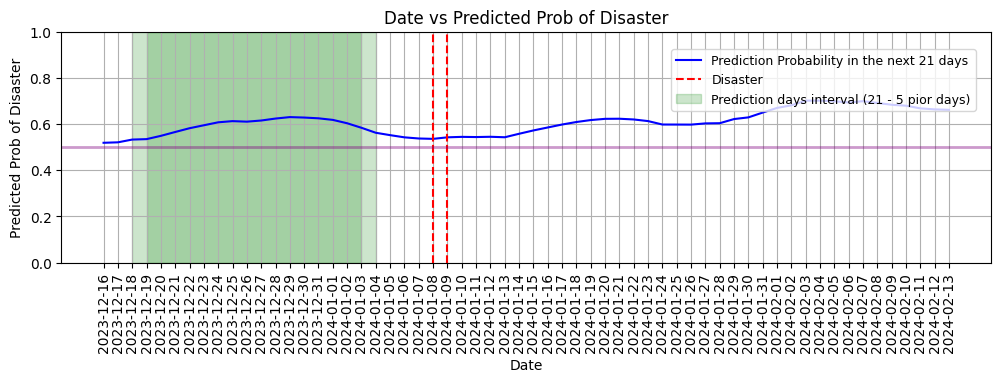

Number of disasters in this period 2
refined_recall when predicting between 21 - 5 days previous a disaster: 1.000
-------------- End of iteration ------------------

Training with 96% of the data
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


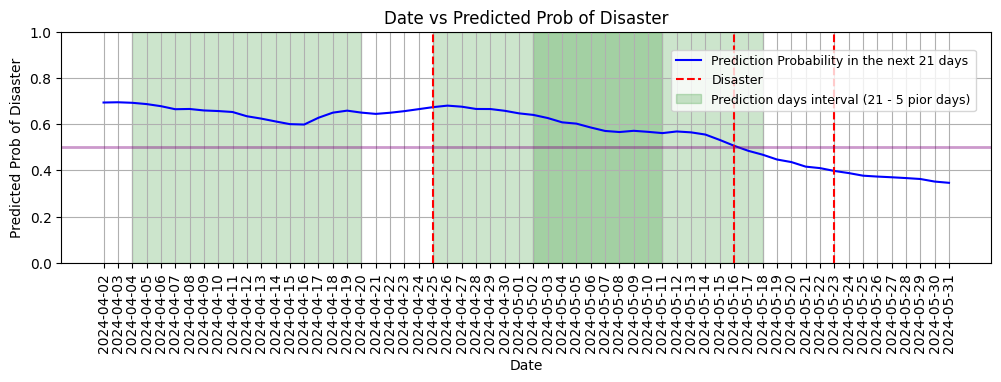

Number of disasters in this period 3
refined_recall when predicting between 21 - 5 days previous a disaster: 1.000
-------------- End of iteration ------------------

Training with 98% of the data
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


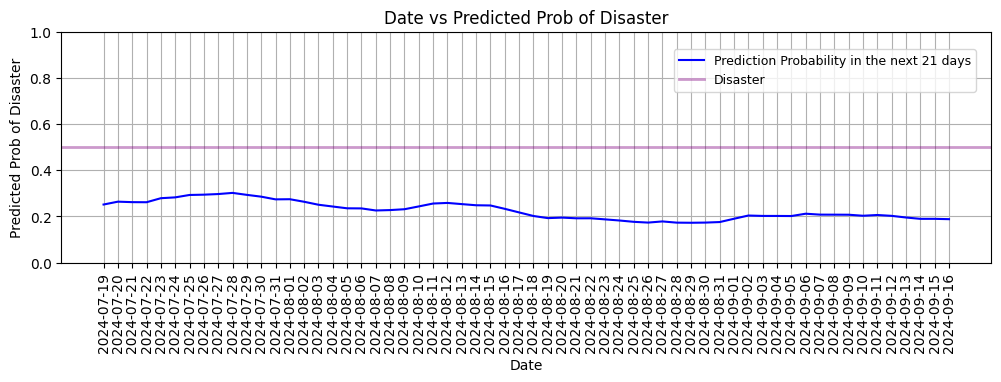

Number of disasters in this period 0
refined_recall when predicting between 21 - 5 days previous a disaster: 0.000
-------------- End of iteration ------------------



In [175]:
# Initialize TimeSplits
thresholds_f1_splits = []
metrics_splits = []
metrics_05_splits = []

# Iterate through the splits
for iter_split_ratio in np.arange(0.90, 0.99, 0.02).tolist():
    print(f"Training with {int(iter_split_ratio*100)}% of the data")

    # Split the data
    X_train, X_val, y_train, y_val = Lstm_classifier().lstm_time_series_train_test_split(scaled_data=scaled_data,
                                                                                        target_column=model_ready_data['target'],  
                                                                                        sequence_length=SEQUENCE_LENGTH, 
                                                                                        train_test_split_ratio=iter_split_ratio)
    
    # readjust the validation set
    if VAL_MAXIMUM_SIZE < X_val.shape[0]:
        X_val_reduced = X_val[:VAL_MAXIMUM_SIZE]
        y_val_reduced = y_val[:VAL_MAXIMUM_SIZE]

    # clean previous info (this is for plots)
    from tensorflow.keras.backend import clear_session
    clear_session()

    # Build LSTM Model
    model = Lstm_classifier().train_lstm(X_train=X_train, 
                                        y_train=y_train, 
                                        units=50, # more units -> more powerful but more time-comsuming and more risk of overfitting
                                        dropout=0.2, # more dropout -> more sleep neurons when traing, less probable to overfit
                                        l2_regularizer_weight=0.001, # how much penalty you want to set for large kernel weight in the loss, large pentalty = more likely to use small kernel weights and not overfit. Set to 0.0 if you do not want l2-regularizer
                                        learning_rate=0.00001,  # less rate -> more slow when learing, less probable to overfit
                                        class_1_weight=2.0, # weight of the 1's class (disaster class), 1.0=same importance as 0's, 5.0=predicting 1's wrong penalizes 5 times more when than 0's. As a reference you can use: class_1_weight=sum(y_train == 0)/sum(y_train == 1)
                                        epochs=5, # number of iterations where lstm goes through the entire dataset
                                        batch_size=32, # how many samples of data are processed together in a single forward and backward pass of the model. For smaller datasets, smaller batch sizes (e.g., 8, 16, or 32) are usually better to ensure the model doesn’t overfit. For large datasets, larger batch sizes (e.g., 64, 128, 256) can speed up training. 
                                        validation_data=(X_val_reduced, y_val_reduced), 
                                        verbose=0,
                                        show_plots=False) # at the end of the training if True, it will plot some monitoring 
    
    # to store the evaluations
    probs_predictions, best_f1_threshold, metrics_best_f1_threshold, metrics_05_threshold = Lstm_classifier().evaluate_lstm(model=model,
                                                                                                                            X_test=X_val_reduced,
                                                                                                                            y_test=y_val_reduced,
                                                                                                                            is_target_adjusted=WANT_TO_ADJUST_TARGET,
                                                                                                                            verbose=0,
                                                                                                                            show_plot=False)
    thresholds_f1_splits.append(best_f1_threshold)
    metrics_splits.append(metrics_best_f1_threshold)
    metrics_05_splits.append(metrics_05_threshold)

    # Post-inference
    # Replicate process but keeping 'ocurred_disaster'
    inference_noaa = Post_inference().prepare_state_version_data_for_inference(data=noaa_counted,
                                                                                selected_state=SELECTED_STATE,
                                                                                n_next_days_until_disaster=N_NEXT_DAYS_UNTIL_DISASTER)
    
    # Replicate split 
    inference_noaa_X_train, inference_noaa_X_val, inference_noaa_y_train, inference_noaa_y_val = Post_inference().inference_lstm_time_series_train_test_split(inference_noaa_date_column=inference_noaa["DATE"],
                                                                                                                                                        inference_noaa_occured_disaster_column=inference_noaa["occured_disaster"],
                                                                                                                                                        sequence_length=SEQUENCE_LENGTH,
                                                                                                                                                        train_test_split_ratio=iter_split_ratio)
    
    # readjust the validation set
    if VAL_MAXIMUM_SIZE < inference_noaa_X_val.shape[0]:
        inference_noaa_X_val_reduced = inference_noaa_X_val[:VAL_MAXIMUM_SIZE]
        inference_noaa_y_val_reduced = inference_noaa_y_val[:VAL_MAXIMUM_SIZE]

    # Join data
    post_inf = Post_inference().create_post_inference_data(inference_noaa_X_test=inference_noaa_X_val_reduced, 
                                                            inference_noaa_y_test=inference_noaa_y_val_reduced, 
                                                            y_test=y_val_reduced, 
                                                            probs_predictions=probs_predictions, 
                                                            selected_threshold=0.5)
    
    # plot
    MINIMUM_DAYS_PRIOR=5
    WANT_TO_PLOT=True
    if WANT_TO_PLOT:
        Post_inference().plot_probs(minimum_days_prior=MINIMUM_DAYS_PRIOR, post_inf=post_inf, n_next_days_until_disaster=N_NEXT_DAYS_UNTIL_DISASTER, plot_width=12, plot_height=3)

    # refined recall
    refined_recall = Post_inference().refine_recall(minimum_days_prior=MINIMUM_DAYS_PRIOR, post_inf=post_inf, n_next_days_until_disaster=N_NEXT_DAYS_UNTIL_DISASTER)

    print("-------------- End of iteration ------------------\n")

In [176]:
# using np.nanmean so metrics with nans (that is zero_division error) are not taken into account
print(f"*****\nSUMMARY for each split: \n -Thresholds {thresholds_f1_splits} \n -(F1, Precision, Recall) with best f1: {metrics_splits}\
       \n -Average Threshold: {np.mean(thresholds_f1_splits)} \n -Average (F1, Precision, Recall): {tuple(np.nanmean(x) for x in zip(*metrics_splits))} \
        \n -Average with threshold = 0.5 (F1, Precision, Recall) {tuple(np.nanmean(x) for x in zip(*metrics_05_splits))}\n*****")

*****
SUMMARY for each split: 
 -Thresholds [0.001, 0, 0.535, 0.001, 0] 
 -(F1, Precision, Recall) with best f1: [(0.7878787878787878, 0.65, 1.0), (0, 0, 0), (0.5454545454545454, 0.375, 1.0), (0.7755102040816326, 0.6333333333333333, 1.0), (0, 0, 0)]       
 -Average Threshold: 0.10740000000000001 
 -Average (F1, Precision, Recall): (0.4217687074829932, 0.33166666666666667, 0.6)         
 -Average with threshold = 0.5 (F1, Precision, Recall) (0.4290070334247041, 0.4046840958605664, 0.5863697705802968)
*****


Now the last model is the one saved